This Jupyter Notebook calculates the Standardized Precipitation Index (SPI) from climate model data, generates time series plots, and analyzes monthly drought trends to assess long-term precipitation variability under different emissions scenarios.

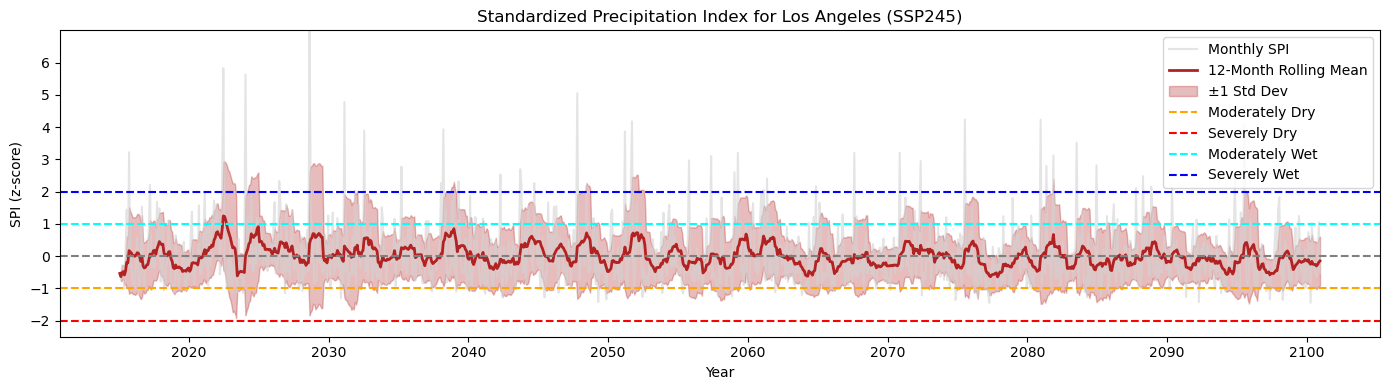

Figure saved as: figures/SPI_Los_Angeles_SSP245.png


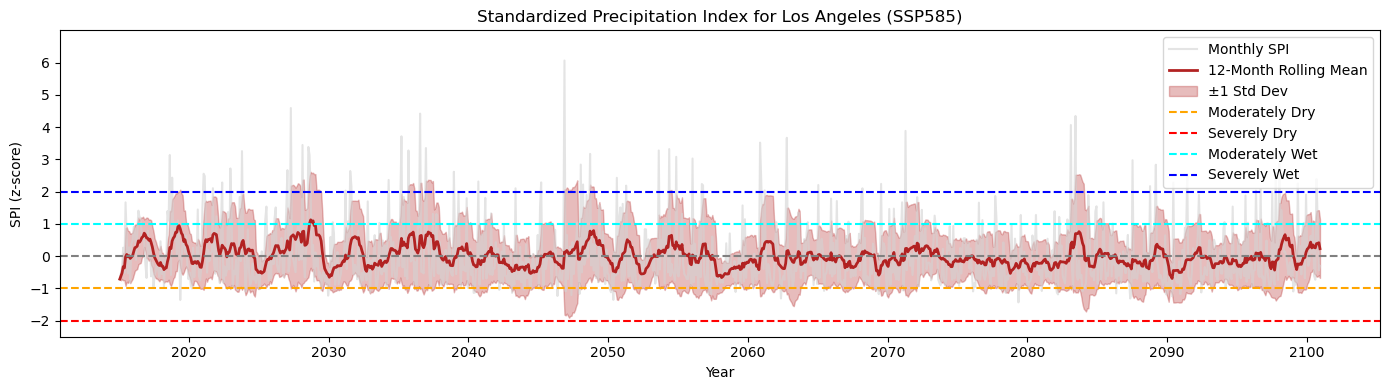

Figure saved as: figures/SPI_Los_Angeles_SSP585.png


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime

# Define parameters - focus only on Los Angeles
LOCATIONS = {
    "Los Angeles": (33.9, 34.3)
}
MODELS = ["CESM2-WACCM"]  # Selected CMIP6 model
SSP_SCENARIOS = ["ssp245", "ssp585"]  # Moderate & High Emission Scenarios
VARIABLES = ["tas", "pr"]  # Temperature & Precipitation
YEARS = slice(2015, 2100)  # Future projections
REFERENCE_PERIOD = (datetime.date(1985, 1, 1), datetime.date(2014, 12, 31))  # Historical baseline

# Los Angeles coordinates for precise selection
LA_LAT = 34.1
LA_LON = -118.3

# Function to extract data for a region
def extract_cmip6_data(dataset, var, lat_range, lon_range):
    if dataset.lon.max() > 180:
        dataset = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180))
        dataset = dataset.sortby('lon')
    ds = dataset[var].sel(lat=slice(*lat_range), lon=slice(*lon_range))
    return ds

# Convert precipitation from kg/m²/s to mm/month
def convert_pr_units(pr_data, time):
    days_in_month = time.dt.days_in_month
    pr_monthly = pr_data * 86400 * days_in_month
    return pr_monthly

# Convert temperature from Kelvin to Celsius
def convert_temp_units(temp_data):
    return temp_data - 273.15

# Function to get historical stats for SPI calculation
def get_historical_pr_stats(hist_pr_path):
    hist_pr_ds = xr.open_dataset(hist_pr_path)
    
    # Extract LA precipitation data
    la_hist_pr = hist_pr_ds['pr'].sel(lat=LA_LAT, lon=LA_LON, method="nearest")
    
    # Convert units to mm
    la_hist_pr_mm = convert_pr_units(la_hist_pr, hist_pr_ds.time)
    
    # Select reference period
    ref_mask = ((hist_pr_ds.time.dt.year >= REFERENCE_PERIOD[0].year) &
                (hist_pr_ds.time.dt.year <= REFERENCE_PERIOD[1].year))
    
    ref_pr = la_hist_pr_mm.sel(time=ref_mask)
    
    # Convert to dataframe for easier manipulation
    ref_pr.name = "pr"
    df = ref_pr.to_dataframe().reset_index()
    
    # Handle cftime objects by extracting the month directly
    # Instead of converting to datetime, extract month directly from cftime objects
    df['month'] = df['time'].apply(lambda x: x.month)
    
    # Calculate monthly means and standard deviations
    monthly_stats = df.groupby('month')['pr'].agg(['mean', 'std']).reset_index()
    
    return monthly_stats

def compute_spi_zscore(pr_data):
    pr_data = pr_data.sel(time=slice("2015-01-01", "2100-12-31"))  # Limit to year 2100
    pr_data.name = "pr"  # Assign name to DataArray
    df = pr_data.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce')
    df = df.dropna(subset=['time'])
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    spi = df.groupby('month')['pr'].transform(lambda x: (x - x.mean()) / x.std())
    df['SPI'] = spi
    return df

def plot_spi(spi_df, title, scenario, region):
    plt.figure(figsize=(14, 4))
    dates = spi_df['time']
    mean_spi = spi_df['SPI']
    rolling_mean = mean_spi.rolling(window=12, min_periods=1).mean()
    rolling_std = mean_spi.rolling(window=12, min_periods=1).std()

    plt.plot(dates, mean_spi, color='lightgray', label='Monthly SPI', alpha=0.6)
    plt.plot(dates, rolling_mean, color='firebrick', lw=2, label='12-Month Rolling Mean')
    plt.fill_between(dates, rolling_mean - rolling_std, rolling_mean + rolling_std,
                     color='firebrick', alpha=0.3, label='±1 Std Dev')
    plt.axhline(0, color='gray', ls='--')
    plt.axhline(-1, color='orange', ls='--', label='Moderately Dry')
    plt.axhline(-2, color='red', ls='--', label='Severely Dry')
    plt.axhline(1, color='cyan', ls='--', label= 'Moderately Wet')
    plt.axhline(2, color='blue', ls='--', label='Severely Wet')
    plt.yticks([-2,-1,0,1,2,3,4,5,6])
    plt.ylim((-2.5,7))
    plt.title(title)
    plt.ylabel('SPI (z-score)')
    plt.xlabel('Year')
    plt.legend()
    plt.tight_layout()
    
    # Create a unique filename based on scenario and region

    filename = f"figures/SPI_{region}_{scenario}.png"
    
    # Save the figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Display the figure
    plt.show()
    
    print(f"Figure saved as: {filename}")

# Load and process scenario data with historical reference
def process_scenario(temp_path, pr_path, scenario_label, hist_pr_path):
    # Get historical monthly stats for SPI calculation
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    
    hist_monthly_stats = get_historical_pr_stats(hist_pr_path)
    
    # Load future scenario data
    pr_ds = xr.open_dataset(pr_path, decode_times=time_coder)
    
    # Extract Los Angeles precipitation data
    la_pr = pr_ds['pr'].sel(lat=LA_LAT, lon=LA_LON, method="nearest")
    la_pr_mm = convert_pr_units(la_pr, pr_ds.time)
    
    # Calculate SPI using historical reference
    spi_df = compute_spi_zscore(la_pr_mm)
    
    # Plot with proper parameters
    plot_spi(spi_df, 
             f"Standardized Precipitation Index for Los Angeles ({scenario_label})", 
             scenario_label, 
             "Los_Angeles")

# Run with historical reference
if __name__ == "__main__":
    hist_pr_path = "datasets/cmip6_pr_historical_CESM2-WACCM.nc"
    
    process_scenario(
        "datasets/cmip6_tas_ssp245_CESM2-WACCM.nc",
        "datasets/cmip6_pr_ssp245_CESM2-WACCM.nc",
        "SSP245",
        hist_pr_path
    )

    process_scenario(
        "datasets/cmip6_tas_ssp585_CESM2-WACCM.nc",
        "datasets/cmip6_pr_ssp585_CESM2-WACCM.nc",
        "SSP585",
        hist_pr_path
    )

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Define parameters
LOCATIONS = {
    "Western US": (30, 49),
    "Los Angeles": (33.9, 34.3),
}
MODELS = ["CESM2-WACCM"]
HISTORICAL_PERIOD = ("1985-01-01", "2014-12-31")
FUTURE_PERIOD = ("2015-01-01", "2100-12-31")

# Define SPI classification according to WMO guidelines
SPI_CLASSES = {
    'W3: extremely wet': (2, float('inf')),
    'W2: severely wet': (1.5, 2),
    'W1: moderately wet': (1, 1.5),
    'N0: normal': (-1, 1),
    'D1: moderately dry': (-1.5, -1),
    'D2: severely dry': (-2, -1.5),
    'D3: extremely dry': (float('-inf'), -2)
}

# Function to extract data for a region
def extract_cmip6_data(dataset, var, lat_range, lon_range):
    if dataset.lon.max() > 180:
        dataset = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180))
        dataset = dataset.sortby('lon')
    ds = dataset[var].sel(lat=slice(*lat_range), lon=slice(*lon_range))
    return ds

# Function to find nearest point to Los Angeles in the dataset
def find_la_point(data_array):
    """Find the nearest grid point to Los Angeles"""
    # Los Angeles coordinates
    target_lat = 34.1
    target_lon = -118.3
    
    # Get available coordinates
    lats = data_array.lat.values
    lons = data_array.lon.values
    
    # Find nearest latitude
    lat_idx = np.abs(lats - target_lat).argmin()
    nearest_lat = lats[lat_idx]
    
    # Find nearest longitude
    lon_idx = np.abs(lons - target_lon).argmin()
    nearest_lon = lons[lon_idx]
    
    print(f"Using coordinates: lat={nearest_lat}, lon={nearest_lon}")
    return nearest_lat, nearest_lon

# Convert precipitation from kg/m²/s to mm/month
def convert_pr_units(pr_data, time):
    days_in_month = time.dt.days_in_month
    pr_monthly = pr_data * 86400 * days_in_month
    return pr_monthly

# SPI approximation using z-score with monthly standardization
def compute_spi_zscore(pr_data, time_period):
    pr_data = pr_data.sel(time=slice(*time_period))
    pr_data.name = "pr"  # Assign name to DataArray
    df = pr_data.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce')
    df = df.dropna(subset=['time'])
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['month_name'] = df['time'].dt.strftime('%b')
    
    # Calculate SPI by standardizing precipitation within each month
    spi = df.groupby('month')['pr'].transform(lambda x: (x - x.mean()) / x.std())
    df['SPI'] = spi
    
    # Add SPI classification based on the provided table
    conditions = [
        (df['SPI'] >= 2),
        (df['SPI'] >= 1.5) & (df['SPI'] < 2),
        (df['SPI'] >= 1) & (df['SPI'] < 1.5),
        (df['SPI'] >= -1) & (df['SPI'] < 1),
        (df['SPI'] >= -1.5) & (df['SPI'] < -1),
        (df['SPI'] >= -2) & (df['SPI'] < -1.5),
        (df['SPI'] < -2)
    ]
    
    choices = [
        'W3: extremely wet',
        'W2: severely wet', 
        'W1: moderately wet',
        'N0: normal',
        'D1: moderately dry',
        'D2: severely dry',
        'D3: extremely dry'
    ]
    
    df['spi_class'] = np.select(conditions, choices, default='N0: normal')
    
    return df

# Analyze monthly SPI class frequency
def analyze_monthly_spi_frequency(spi_df, period_label):
    # Get all SPI classes in order
    spi_classes = [
        'D3: extremely dry', 
        'D2: severely dry', 
        'D1: moderately dry',
        'N0: normal',
        'W1: moderately wet',
        'W2: severely wet',
        'W3: extremely wet'
    ]
    
    # Calculate frequency by month across all years
    monthly_spi = pd.DataFrame(index=range(1, 13))
    
    # For each SPI class, calculate frequency by month
    for spi_class in spi_classes:
        monthly_counts = spi_df[spi_df['spi_class'] == spi_class].groupby('month').size()
        total_counts = spi_df.groupby('month').size()
        monthly_freq = (monthly_counts / total_counts * 100).fillna(0)
        monthly_spi[spi_class] = monthly_freq
    
    # Add month names for better visualization
    monthly_spi['month_name'] = [calendar.month_abbr[m] for m in monthly_spi.index]
    monthly_spi['period'] = period_label
    
    return monthly_spi

# Function to plot SPI frequencies with side-by-side bars (improved clarity)
def plot_improved_spi_visualization(historical_df, ssp245_df, ssp585_df):
    # Define the SPI categories and their colors
    categories = [
        'D3: extremely dry', 
        'D2: severely dry', 
        'D1: moderately dry',
        'N0: normal',
        'W1: moderately wet',
        'W2: severely wet',
        'W3: extremely wet'
    ]
    
    colors = {
        'D3: extremely dry': '#800000',    # Dark red
        'D2: severely dry': '#FF0000',     # Red
        'D1: moderately dry': '#FFA500',   # Orange
        'N0: normal': 'k',           # Black
        'W1: moderately wet': '#ADD8E6',   # Light blue
        'W2: severely wet': '#0000FF',     # Blue
        'W3: extremely wet': '#00008B'     # Dark blue
    }
    
    # Create figure with 3 rows (one for each category group)
    fig, axes = plt.subplots(3, 1, figsize=(18, 20))
    
    # Titles for each plot
    titles = [
        "Dry Conditions (SPI < -1)",
        "Normal Conditions (-1 ≤ SPI < 1)",
        "Wet Conditions (SPI ≥ 1)"
    ]
    
    # Group categories
    dry_categories = ['D3: extremely dry', 'D2: severely dry', 'D1: moderately dry']
    normal_categories = ['N0: normal']
    wet_categories = ['W1: moderately wet', 'W2: severely wet', 'W3: extremely wet']
    category_groups = [dry_categories, normal_categories, wet_categories]
    
    # Plot each category group
    for i, (cat_group, title) in enumerate(zip(category_groups, titles)):
        ax = axes[i]
        
        # Set up months
        months = range(1, 13)
        x = np.arange(len(months))
        width = 0.25  # Width of bars
        
        # Plot each dataset with different offsets for clarity
        plot_category_group(ax, historical_df, cat_group, colors, x, width*0, "Historical (1985-2014)")
        plot_category_group(ax, ssp245_df, cat_group, colors, x, width, "SSP245 (2015-2100)")
        plot_category_group(ax, ssp585_df, cat_group, colors, x, width*2, "SSP585 (2015-2100)")
        
        # Set x-axis labels and ticks
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel('Frequency (%)', fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.set_xticks(x + width)
        ax.set_xticklabels([calendar.month_abbr[m] for m in months])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add legend
        if i == 0:  # Only add the scenario legend to the first plot
            scenario_handles = [
                plt.Rectangle((0,0),1,1, facecolor='#F5DEB3', edgecolor='black', linewidth=1),
                plt.Rectangle((0,0),1,1, facecolor='#DCDCDC', edgecolor='black', linewidth=1),
                plt.Rectangle((0,0),1,1, facecolor='#D3D3D3', edgecolor='black', linewidth=1)
            ]
            ax.legend(scenario_handles, ["Historical (1985-2014)", "SSP245 (2015-2100)", "SSP585 (2015-2100)"], 
                      loc='upper right', fontsize=12)
    
    # Add a color legend for all categories in a separate axis area
    fig.subplots_adjust(bottom=0.15)
    legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.05])
    legend_ax.axis('off')
    
    # Create color patches for the legend
    category_handles = []
    for cat in categories:
        category_handles.append(plt.Rectangle((0,0),1,1, facecolor=colors[cat], edgecolor='black', linewidth=1))
    
    legend_ax.legend(category_handles, categories, loc='center', ncol=len(categories), fontsize=14)
    
    # Add overall title
    plt.suptitle('SPI Class Frequency Comparison in Los Angeles: Historical vs Future Projections', 
                 fontsize=18, y=0.98)
    
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])
    plt.savefig('improved_spi_frequency_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Function to plot a category group on a specific axis
def plot_category_group(ax, df, categories, colors, x, offset, label):
    # Set base colors for each scenario
    base_colors = {
        "Historical (1985-2014)": '#F5DEB3',  # Wheat
        "SSP245 (2015-2100)": '#DCDCDC',      # Gainsboro
        "SSP585 (2015-2100)": '#D3D3D3'       # Light gray
    }
    
    # For each category in the group, plot it individually
    for cat in categories:
        if cat in df.columns:
            # Get the values and lighten the color a bit based on the base color
            values = df[cat].values
            color = colors[cat]
            
            # Plot the bar for this category
            bar = ax.bar(x + offset, values, width=0.25, color=color, 
                    edgecolor='black', linewidth=0.5, alpha=0.9)
            
            # Add value labels on top of each bar
            for i, v in enumerate(values):
                if v >= 5:  # Only label if value is significant
                    ax.text(x[i] + offset, v + 1, f'{v:.1f}%', 
                           ha='center', fontsize=11)
    
    # Add thin borders to distinguish the datasets better
    ax.bar(x + offset, np.zeros(len(x)), width=0.25, 
           edgecolor='black', linewidth=1, fill=False)

# Alternative visualization - line plot with uncertainty bands
def plot_spi_line_visualization(historical_df, ssp245_df, ssp585_df):
    # Group categories for simplification
    category_groups = {
        'Dry (SPI < -1)': ['D3: extremely dry', 'D2: severely dry', 'D1: moderately dry'],
        'Normal (-1 ≤ SPI < 1)': ['N0: normal'],
        'Wet (SPI ≥ 1)': ['W1: moderately wet', 'W2: severely wet', 'W3: extremely wet']
    }
    
    # Colors for each condition
    colors = {
        'Dry (SPI < -1)': '#FF4500',     # Red-orange
        'Normal (-1 ≤ SPI < 1)': 'k',  # black
        'Wet (SPI ≥ 1)': '#4169E1'       # Royal blue
    }
    
    # Create a figure with 3 subplots (one for each condition)
    fig, axes = plt.subplots(3, 1, figsize=(16, 15))
    
    # Process each condition type
    for i, (condition_name, categories) in enumerate(category_groups.items()):
        ax = axes[i]
        
        # Sum up the percentages for each category in the group
        hist_values = sum(historical_df[cat] for cat in categories if cat in historical_df.columns)
        ssp245_values = sum(ssp245_df[cat] for cat in categories if cat in ssp245_df.columns)
        ssp585_values = sum(ssp585_df[cat] for cat in categories if cat in ssp585_df.columns)
        
        # Months for x-axis
        months = range(1, 13)
        month_names = [calendar.month_abbr[m] for m in months]
        
        # Plot lines
        ax.plot(months, hist_values, 'o-', color=colors[condition_name], linewidth=2, 
                label='Historical (1985-2014)', markersize=8)
        ax.plot(months, ssp245_values, 's--', color=colors[condition_name], linewidth=2, 
                label='SSP245 (2015-2100)', markersize=8, alpha=0.7)
        ax.plot(months, ssp585_values, '^-.', color=colors[condition_name], linewidth=2, 
                label='SSP585 (2015-2100)', markersize=8, alpha=0.7)
        
        # Add annotations for key points
        for m, (h, s245, s585) in enumerate(zip(hist_values, ssp245_values, ssp585_values)):
            ax.text(months[m], h, f'{h:.1f}%', ha='center', va='bottom', fontsize=9)
            
            # Only annotate if there's a significant change
            if abs(s245 - h) > 5:
                ax.text(months[m], s245, f'{s245:.1f}%', ha='center', va='bottom', fontsize=9)
            if abs(s585 - h) > 5:
                ax.text(months[m], s585, f'{s585:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Customize the plot
        ax.set_title(f'{condition_name} Conditions Monthly Frequency', fontsize=16)
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel('Frequency (%)', fontsize=14)
        ax.set_xticks(months)
        ax.set_xticklabels(month_names)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right')
        
        # Set y-axis limit based on data values
        max_val = max(max(hist_values), max(ssp245_values), max(ssp585_values))
        ax.set_ylim(0, max_val * 1.2)  # Add 20% padding
    
    plt.suptitle('Monthly SPI Condition Frequency: Historical vs Future Scenarios', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('spi_frequency_line_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main function
def main():
    print("Loading datasets...")

    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
      
    # Load historical data
    hist_pr_ds = xr.open_dataset("datasets/cmip6_pr_historical_CESM2-WACCM.nc",decode_times=time_coder)
    
    # Load future projections
    ssp245_pr_ds = xr.open_dataset("datasets/cmip6_pr_ssp245_CESM2-WACCM.nc",decode_times=time_coder)
    ssp585_pr_ds = xr.open_dataset("datasets/cmip6_pr_ssp585_CESM2-WACCM.nc",decode_times=time_coder)

    # Extract data for Western US (broader region)
    lat_range = LOCATIONS['Western US']
    lon_range = (-125, -100)  # Western US longitude range
    
    print("Extracting regional data...")
    hist_pr = extract_cmip6_data(hist_pr_ds, 'pr', lat_range, lon_range)
    ssp245_pr = extract_cmip6_data(ssp245_pr_ds, 'pr', lat_range, lon_range)
    ssp585_pr = extract_cmip6_data(ssp585_pr_ds, 'pr', lat_range, lon_range)
    
    # Find nearest point to Los Angeles in each dataset
    print("Finding Los Angeles coordinates in historical dataset...")
    hist_lat, hist_lon = find_la_point(hist_pr)
    
    print("Finding Los Angeles coordinates in SSP245 dataset...")
    ssp245_lat, ssp245_lon = find_la_point(ssp245_pr)
    
    print("Finding Los Angeles coordinates in SSP585 dataset...")
    ssp585_lat, ssp585_lon = find_la_point(ssp585_pr)
    
    # Get point data for LA using nearest available coordinates
    print("Extracting LA point data...")
    hist_la_pr = hist_pr.sel(lat=hist_lat, lon=hist_lon)
    ssp245_la_pr = ssp245_pr.sel(lat=ssp245_lat, lon=ssp245_lon)
    ssp585_la_pr = ssp585_pr.sel(lat=ssp585_lat, lon=ssp585_lon)
    
    # Convert precipitation to mm/month
    print("Converting precipitation units...")
    hist_la_pr_mm = convert_pr_units(hist_la_pr, hist_pr.time)
    ssp245_la_pr_mm = convert_pr_units(ssp245_la_pr, ssp245_pr.time)
    ssp585_la_pr_mm = convert_pr_units(ssp585_la_pr, ssp585_pr.time)
    
    print("Computing SPIs...")
    # Compute SPI values
    hist_spi_df = compute_spi_zscore(hist_la_pr_mm, HISTORICAL_PERIOD)
    ssp245_spi_df = compute_spi_zscore(ssp245_la_pr_mm, FUTURE_PERIOD)
    ssp585_spi_df = compute_spi_zscore(ssp585_la_pr_mm, FUTURE_PERIOD)
    
    print("Analyzing monthly SPI class frequencies...")
    # Analyze monthly SPI frequencies
    hist_monthly_spi = analyze_monthly_spi_frequency(hist_spi_df, "Historical")
    ssp245_monthly_spi = analyze_monthly_spi_frequency(ssp245_spi_df, "SSP245")
    ssp585_monthly_spi = analyze_monthly_spi_frequency(ssp585_spi_df, "SSP585")
    
    print("Creating improved bar chart visualization...")
    # Plot the improved bar chart visualization
    plot_improved_spi_visualization(hist_monthly_spi, ssp245_monthly_spi, ssp585_monthly_spi)
    
    print("Creating alternative line plot visualization...")
    # Plot the alternative line visualization
    plot_spi_line_visualization(hist_monthly_spi, ssp245_monthly_spi, ssp585_monthly_spi)
    
    # Optional: Save the data for further analysis
    hist_monthly_spi.to_csv('historical_monthly_spi.csv')
    ssp245_monthly_spi.to_csv('ssp245_monthly_spi.csv')
    ssp585_monthly_spi.to_csv('ssp585_monthly_spi.csv')
    
    print("Analysis complete! Visualizations have been saved.")

# Run main function
if __name__ == "__main__":
    main()

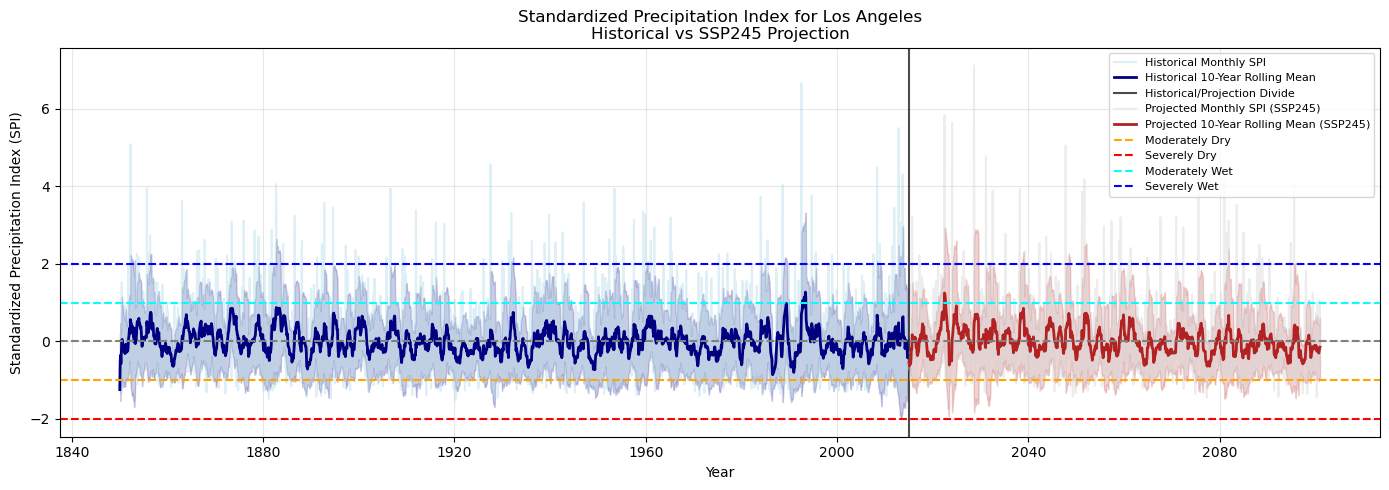

Figure saved as: figures/SPI_comparison_Los_Angeles_SSP245.png


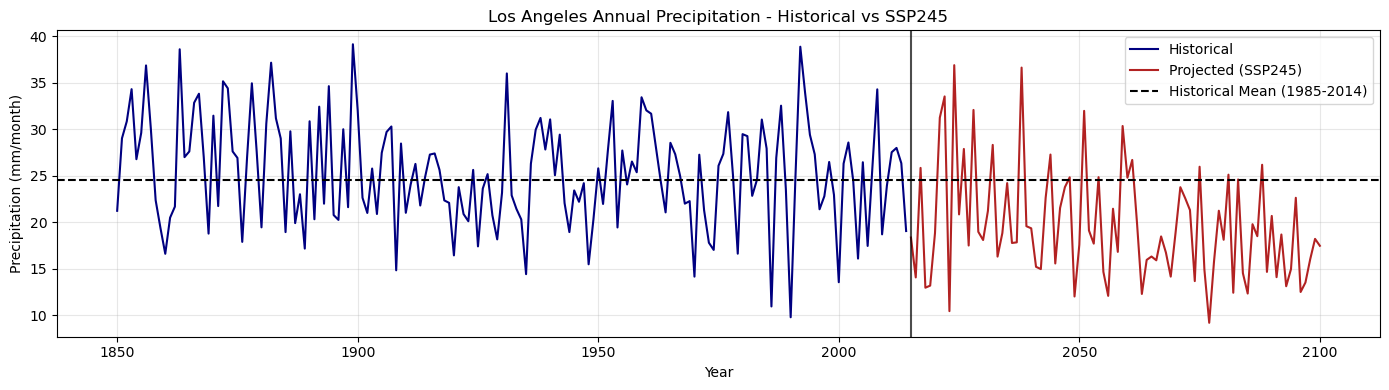

Figure saved as: figures/Annual_Precip_Comparison_Los_Angeles_SSP245.png


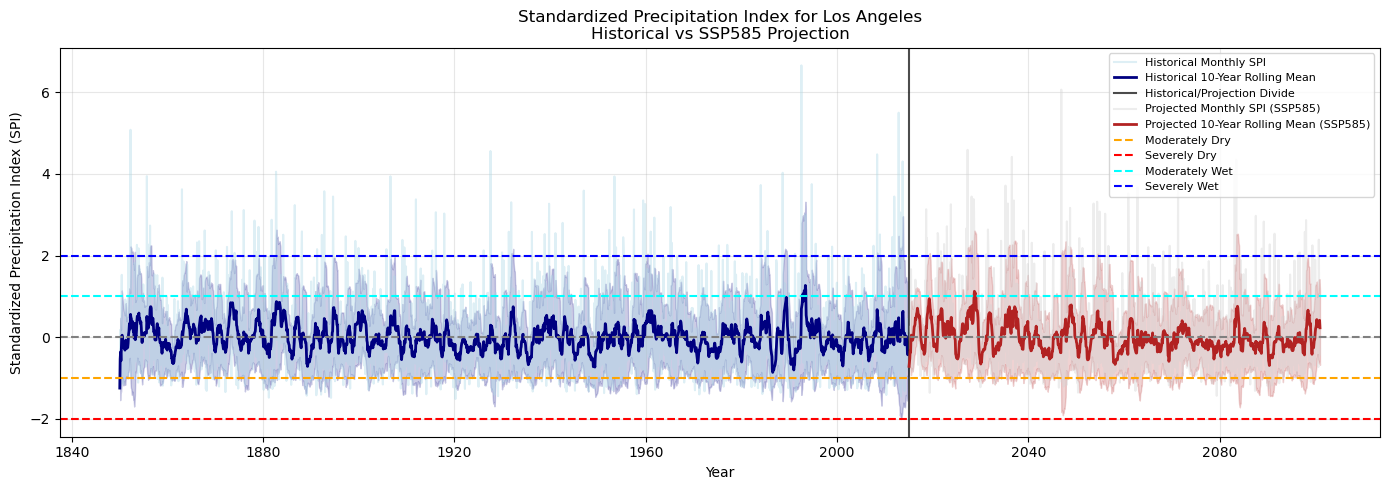

Figure saved as: figures/SPI_comparison_Los_Angeles_SSP585.png


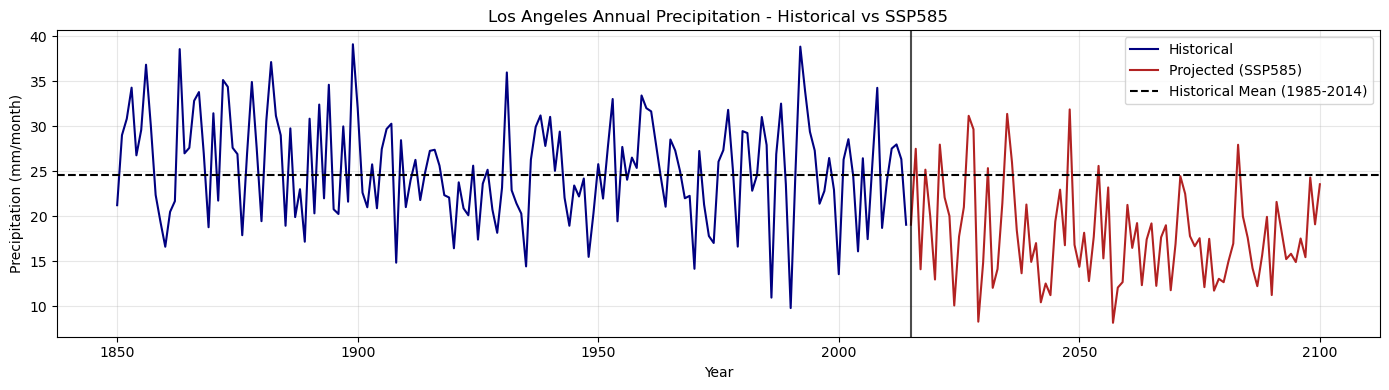

Figure saved as: figures/Annual_Precip_Comparison_Los_Angeles_SSP585.png


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime

# Define parameters - focus only on Los Angeles
LOCATIONS = {
    "Los Angeles": (33.9, 34.3)
}
MODELS = ["CESM2-WACCM"]  # Selected CMIP6 model
SSP_SCENARIOS = ["ssp245", "ssp585"]  # Moderate & High Emission Scenarios
VARIABLES = ["tas", "pr"]  # Temperature & Precipitation
YEARS = slice(2015, 2100)  # Future projections
REFERENCE_PERIOD = (datetime.date(1985, 1, 1), datetime.date(2014, 12, 31))  # Historical baseline

# Los Angeles coordinates for precise selection
LA_LAT = 34.1
LA_LON = -118.3

# Function to extract data for a region
def extract_cmip6_data(dataset, var, lat_range, lon_range):
    if dataset.lon.max() > 180:
        dataset = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180))
        dataset = dataset.sortby('lon')
    ds = dataset[var].sel(lat=slice(*lat_range), lon=slice(*lon_range))
    return ds

# Convert precipitation from kg/m²/s to mm/month
def convert_pr_units(pr_data, time):
    days_in_month = time.dt.days_in_month
    pr_monthly = pr_data * 86400 * days_in_month
    return pr_monthly

# Convert temperature from Kelvin to Celsius
def convert_temp_units(temp_data):
    return temp_data - 273.15

# Function to get historical stats for SPI calculation
def get_historical_pr_stats(hist_pr_path):
    hist_pr_ds = xr.open_dataset(hist_pr_path)
    
    # Extract LA precipitation data
    la_hist_pr = hist_pr_ds['pr'].sel(lat=LA_LAT, lon=LA_LON, method="nearest")
    
    # Convert units to mm
    la_hist_pr_mm = convert_pr_units(la_hist_pr, hist_pr_ds.time)
    
    # Select reference period
    ref_mask = ((hist_pr_ds.time.dt.year >= REFERENCE_PERIOD[0].year) &
                (hist_pr_ds.time.dt.year <= REFERENCE_PERIOD[1].year))
    
    ref_pr = la_hist_pr_mm.sel(time=ref_mask)
    
    # Convert to dataframe for easier manipulation
    ref_pr.name = "pr"
    df = ref_pr.to_dataframe().reset_index()
    
    # Handle cftime objects by extracting the month directly
    df['month'] = df['time'].apply(lambda x: x.month)
    
    # Calculate monthly means and standard deviations
    monthly_stats = df.groupby('month')['pr'].agg(['mean', 'std']).reset_index()
    
    return monthly_stats, df

def compute_historical_spi(hist_pr_path):
    """Process historical data and compute SPI"""
    hist_pr_ds = xr.open_dataset(hist_pr_path)
    
    # Extract LA precipitation data
    la_hist_pr = hist_pr_ds['pr'].sel(lat=LA_LAT, lon=LA_LON, method="nearest")
    
    # Convert units to mm
    la_hist_pr_mm = convert_pr_units(la_hist_pr, hist_pr_ds.time)
    
    # Compute SPI
    la_hist_pr_mm.name = "pr"
    hist_df = la_hist_pr_mm.to_dataframe().reset_index()
    hist_df['time'] = pd.to_datetime(hist_df['time'].astype(str), errors='coerce')
    hist_df = hist_df.dropna(subset=['time'])
    hist_df['month'] = hist_df['time'].dt.month
    hist_df['year'] = hist_df['time'].dt.year
    
    hist_spi = hist_df.groupby('month')['pr'].transform(lambda x: (x - x.mean()) / x.std())
    hist_df['SPI'] = hist_spi
    
    return hist_df

def compute_spi_zscore(pr_data):
    pr_data = pr_data.sel(time=slice("2015-01-01", "2100-12-31"))  # Limit to year 2100
    pr_data.name = "pr"  # Assign name to DataArray
    df = pr_data.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce')
    df = df.dropna(subset=['time'])
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    spi = df.groupby('month')['pr'].transform(lambda x: (x - x.mean()) / x.std())
    df['SPI'] = spi
    return df

def plot_spi(spi_df, hist_spi_df, title, scenario, region):
    plt.figure(figsize=(14, 5))
    
    # Plot historical SPI
    hist_dates = hist_spi_df['time']
    hist_spi = hist_spi_df['SPI']
    hist_rolling_mean = hist_spi.rolling(window=12, min_periods=1).mean()  # 10-year rolling window (120 months)
    hist_rolling_std = hist_spi.rolling(window=12, min_periods=1).std()
    
    plt.plot(hist_dates, hist_spi, color='lightblue', alpha=0.4, label='Historical Monthly SPI')
    plt.plot(hist_dates, hist_rolling_mean, color='navy', lw=2, label='Historical 10-Year Rolling Mean')
    plt.fill_between(hist_dates, hist_rolling_mean - hist_rolling_std, hist_rolling_mean + hist_rolling_std,
                     color='navy', alpha=0.2)
    
    # Plot vertical line separating historical from projection
    plt.axvline(pd.Timestamp('2015-01-01'), color='black', linestyle='-', alpha=0.7, label='Historical/Projection Divide')
    
    # Plot future SPI
    future_dates = spi_df['time']
    future_spi = spi_df['SPI']
    future_rolling_mean = future_spi.rolling(window=12, min_periods=1).mean()
    future_rolling_std = future_spi.rolling(window=12, min_periods=1).std()
    
    plt.plot(future_dates, future_spi, color='lightgray', alpha=0.4, label=f'Projected Monthly SPI ({scenario})')
    plt.plot(future_dates, future_rolling_mean, color='firebrick', lw=2, label=f'Projected 10-Year Rolling Mean ({scenario})')
    plt.fill_between(future_dates, future_rolling_mean - future_rolling_std, future_rolling_mean + future_rolling_std,
                     color='firebrick', alpha=0.2)
    
    # Add reference lines
    plt.axhline(0, color='gray', ls='--')
    plt.axhline(-1, color='orange', ls='--', label='Moderately Dry')
    plt.axhline(-2, color='red', ls='--', label='Severely Dry')
    plt.axhline(1, color='cyan', ls='--', label='Moderately Wet')
    plt.axhline(2, color='blue', ls='--', label='Severely Wet')
    
    plt.title(title)
    plt.ylabel('Standardized Precipitation Index (SPI)')
    plt.xlabel('Year')
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Create a unique filename based on scenario and region
    filename = f"figures/SPI_comparison_{region}_{scenario}.png"
    
    # Save the figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Display the figure
    plt.show()
    
    print(f"Figure saved as: {filename}")

# Load and process scenario data with historical reference
def process_scenario(temp_path, pr_path, scenario_label, hist_pr_path):
    # Get historical monthly stats for SPI calculation
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    
    hist_monthly_stats, _ = get_historical_pr_stats(hist_pr_path)
    
    # Compute historical SPI
    hist_spi_df = compute_historical_spi(hist_pr_path)
    
    # Load future scenario data
    pr_ds = xr.open_dataset(pr_path, decode_times=time_coder)
    
    # Extract Los Angeles precipitation data
    la_pr = pr_ds['pr'].sel(lat=LA_LAT, lon=LA_LON, method="nearest")
    la_pr_mm = convert_pr_units(la_pr, pr_ds.time)
    
    # Calculate SPI using historical reference
    spi_df = compute_spi_zscore(la_pr_mm)
    
    # Plot with proper parameters including historical comparison
    plot_spi(spi_df, 
             hist_spi_df,
             f"Standardized Precipitation Index for Los Angeles\nHistorical vs {scenario_label} Projection", 
             scenario_label, 
             "Los_Angeles")
    
    # Additional analysis - show annual precipitation trend
    annual_pr = spi_df.groupby('year')['pr'].mean().reset_index()
    hist_annual_pr = hist_spi_df.groupby('year')['pr'].mean().reset_index()
    
    plt.figure(figsize=(14, 4))
    plt.plot(hist_annual_pr['year'], hist_annual_pr['pr'], color='navy', label='Historical')
    plt.plot(annual_pr['year'], annual_pr['pr'], color='firebrick', label=f'Projected ({scenario_label})')
    plt.axhline(hist_monthly_stats['mean'].mean(), color='black', linestyle='--', 
                label=f'Historical Mean ({REFERENCE_PERIOD[0].year}-{REFERENCE_PERIOD[1].year})')
    plt.axvline(2015, color='black', linestyle='-', alpha=0.7)
    plt.title(f"Los Angeles Annual Precipitation - Historical vs {scenario_label}")
    plt.ylabel("Precipitation (mm/month)")
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save annual precipitation plot
    filename = f"figures/Annual_Precip_Comparison_Los_Angeles_{scenario_label}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure saved as: {filename}")

# Run with historical reference
if __name__ == "__main__":
    hist_pr_path = "datasets/cmip6_pr_historical_CESM2-WACCM.nc"
    
    process_scenario(
        "datasets/cmip6_tas_ssp245_CESM2-WACCM.nc",
        "datasets/cmip6_pr_ssp245_CESM2-WACCM.nc",
        "SSP245",
        hist_pr_path
    )

    process_scenario(
        "datasets/cmip6_tas_ssp585_CESM2-WACCM.nc",
        "datasets/cmip6_pr_ssp585_CESM2-WACCM.nc",
        "SSP585",
        hist_pr_path
    )